# 感情分析、社員レビューデータ

### ライブラリ読み込み

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from janome.tokenizer import Tokenizer
import re
import seaborn as sns
%matplotlib inline
from transformers import *
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from wordcloud import WordCloud
import gc
import random

Mounted at /content/drive


In [3]:
#google colab gpu
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Tue Oct 18 11:28:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    49W / 400W |   1212MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#batch size, validation split
BATCH_SIZE = 16
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
#token length
MAX_LEN = 408
MAX_LEN_1 = 368

# データ読み込み

In [6]:
# 学習データ
DATA_IN_PATH = "/content/drive/My Drive/Colab Notebooks/"
train_data_a=pd.read_csv(DATA_IN_PATH + 'a_train_2020.csv',header=0,encoding="cp932",quoting=3)
train_data_b=pd.read_csv(DATA_IN_PATH + 'b_train_3953.csv',header=0,encoding="cp932",quoting=3)
train_data_a.head(2)

# トークン化

# tokenizerローディング

In [9]:
model_name_bert = "cl-tohoku/bert-base-japanese-v2" 
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_bert, cache_dir='bert_ckpt')

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

loading file vocab.txt from cache at bert_ckpt/models--cl-tohoku--bert-base-japanese-v2/snapshots/e4211d7c20b078ac29b022be35ae4b63f3fe1679/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at bert_ckpt/models--cl-tohoku--bert-base-japanese-v2/snapshots/e4211d7c20b078ac29b022be35ae4b63f3fe1679/tokenizer_config.json


Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

loading configuration file config.json from cache at bert_ckpt/models--cl-tohoku--bert-base-japanese-v2/snapshots/e4211d7c20b078ac29b022be35ae4b63f3fe1679/config.json
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-v2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32768
}



In [10]:
#tokenizer test

lines="MBAは格好いい人がいる"
inputs = tokenizer(lines, return_tensors="pt")
print(inputs)
print(tokenizer.decode(inputs["input_ids"][0]))
print(tokenizer.tokenize(lines))

{'input_ids': tensor([[    2, 21041,  6203,   897, 19693, 12365,  1104,   862, 11138,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
[CLS] MBA は 格好 いい 人 が いる [SEP]
['MB', '##A', 'は', '格好', 'いい', '人', 'が', 'いる']


In [11]:
# encoding関数定義
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(text = sent,
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        pad_to_max_length = True,
                                        return_attention_mask = True)
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

## train_data_a encoding

In [12]:
#結果リスト
input_ids_a=[]
attention_masks_a=[]
token_type_ids_a=[]
train_labels_a=[]

# loopでencoding
for train_sent, train_label in tqdm(zip(train_data_a['review_cleansing'],train_data_a['label3']),total=len(train_data_a)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids_a.append(input_id)
        attention_masks_a.append(attention_mask)
        token_type_ids_a.append(token_type_id)
        train_labels_a.append(train_label)
 
    except Exception as e:
        print(e)
        print(train_sent)
        pass

# リストをnumpy配列に変換   
train_a_input_ids = np.array(input_ids_a,dtype=int) 
train_a_attention_masks=np.array(attention_masks_a, dtype=int)
train_a_type_ids = np.array(token_type_ids_a, dtype=int)


train_a_inputs = (train_a_input_ids, train_a_attention_masks, train_a_type_ids)


train_a_labels=np.asarray(train_labels_a, dtype=np.int32)

#学習データ数、ラベル確認

print("# sents: {}, # labels: {}".format(len(train_a_input_ids), len(train_a_labels)))

  0%|          | 0/2020 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 2020/2020 [00:01<00:00, 1769.19it/s]


# sents: 2020, # labels: 2020


In [13]:
# encodingされたベクトルの確認

input_id = train_a_input_ids[199]
attention_mask = train_a_attention_masks[199]
token_type_id = train_a_type_ids[199]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[    2 12938   896 13604   897 24683   889   916 11175 12343 16533   896
 14647   889 18394   897 11771 11158 13276   881 11500  2320 11265 13854
   889   897 12868   889   916 18394   932  2592 11263 11169 13500   873
   888 11245   881  2706   862 12365 12461 11582   897 27780  3775   892
 21301 12461 11772  3775   893 19211   890   896 16135   897 11334 13372
   890 12139 12343   862 13854   893 11195   890 12139 12343 11980   896
 13431   889 13037   898 12205 29177   918 11649   893 11195 12915   862
 11396 15171 12461   862  2135  5479   918 26415   897 11402 26086   918
 11558  1422   916 15122   896  1037 17982   871   926 15125 15171 16618
   881 11145 11152 16599   893  1037   896  2706   889   916 13463 13372
 15171 16618   881 13854   897  3697   862 11396 12461   862 11199   889
   916 14435   893 11195  2140   897 11702 23952 11158 15583   933 16618
   881 18155 15592  3775   892 17052   896  2140   897  1370   888   863
 12343     3     0     0     0     0     0     0   

## train_data_b encoding

In [14]:
input_ids_b=[]
attention_masks_b=[]
token_type_ids_b=[]
train_labels_b=[]

for train_sent, train_label in tqdm(zip(train_data_b['review_cleansing'],train_data_b['label3']),total=len(train_data_b)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN_1)
        
        input_ids_b.append(input_id)
        attention_masks_b.append(attention_mask)
        token_type_ids_b.append(token_type_id)
        train_labels_b.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass
    
train_b_input_ids = np.array(input_ids_b,dtype=int) 
train_b_attention_masks=np.array(attention_masks_b, dtype=int)
train_b_type_ids = np.array(token_type_ids_b, dtype=int)
train_b_inputs = (train_b_input_ids, train_b_attention_masks, train_b_type_ids)
train_b_labels=np.asarray(train_labels_b, dtype=np.int32)

print("# sents: {}, # labels: {}".format(len(train_b_input_ids), len(train_b_labels)))

100%|██████████| 3953/3953 [00:02<00:00, 1741.30it/s]


# sents: 3953, # labels: 3953


In [15]:
input_id = train_b_input_ids[224]
attention_mask = train_b_attention_masks[224]
token_type_id = train_b_type_ids[224]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[    2 13087 11319   897  5479 11191   881 12461   862 11943   893 13978
 17567   862 11175 13187   862 18371   873   888 13276   881 11818  1422
   862 12953   896   897 19944 11148   890 12139 12343 11168 12279  2470
   896 11169   889 11576   889 15119   888 11497   896   889 22897  2402
   896 11169   892 11171   897 12935   876   893 18728 13276   881 14239
  1104   893   897   948   963  6169  6226 12461     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

# BERT ローディング

In [16]:
class TFBertClassifier (tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="classifier")
    def call(self, inputs, attention_mask=None , token_type_ids=None , training=False):
        
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        
        return logits
    

review_model_a = TFBertClassifier(model_name="cl-tohoku/bert-base-japanese-v2",dir_path='bert_ckpt',num_class=2)
review_model_b = TFBertClassifier(model_name="cl-tohoku/bert-base-japanese-v2",dir_path='bert_ckpt',num_class=2)

loading configuration file config.json from cache at bert_ckpt/models--cl-tohoku--bert-base-japanese-v2/snapshots/e4211d7c20b078ac29b022be35ae4b63f3fe1679/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32768
}



Downloading:   0%|          | 0.00/550M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at bert_ckpt/models--cl-tohoku--bert-base-japanese-v2/snapshots/e4211d7c20b078ac29b022be35ae4b63f3fe1679/tf_model.h5
Some layers from the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions 

# hyperparameter　設定

In [17]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
review_model_a.compile(optimizer=optimizer, loss=loss, metrics=[metric])
review_model_b.compile(optimizer=optimizer, loss=loss, metrics=[metric])

#SparseCategoricalCrossentropy 多重分類　整数ラベル
#CategoricalCrossentropy 多重分類　onehotエンコーディングラベル
#binary cross entrophy　二項分類

# overfitting防止設定

In [18]:
model_names = "tf2_bert_review_a"
DATA_OUT_PATH="/content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/"
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)


checkpoint_path = os.path.join(DATA_OUT_PATH, model_names, "weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create! \n".format(checkpoint_dir))
    
cp_callback_a = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/tf2_bert_review_a -- Folder create! 



# modelfit 学習

### train_a modelfit and 学習

In [19]:
# 学習
history = review_model_a.fit(train_a_inputs, train_a_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback_a])

print(history.history)

Epoch 1/10
114/114 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7420
Epoch 1: val_accuracy improved from -inf to 0.69307, saving model to /content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/tf2_bert_review_a/weights.h5
114/114 [==============================] - 49s 233ms/step - loss: 0.5454 - accuracy: 0.7420 - val_loss: 0.7017 - val_accuracy: 0.6931
Epoch 2/10
114/114 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8790
Epoch 2: val_accuracy did not improve from 0.69307
114/114 [==============================] - 22s 193ms/step - loss: 0.3067 - accuracy: 0.8790 - val_loss: 1.0172 - val_accuracy: 0.6485
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9565
Epoch 3: val_accuracy improved from 0.69307 to 0.75248, saving model to /content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/tf2_bert_review_a/weights.h5
114/114 [==============================] - 25s 221ms/step - loss: 0.1253 - accuracy: 0

In [20]:
# グラフ
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

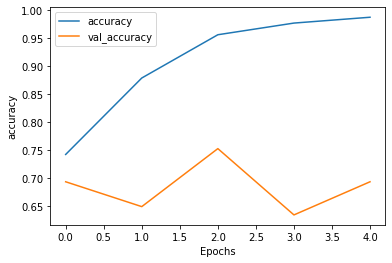

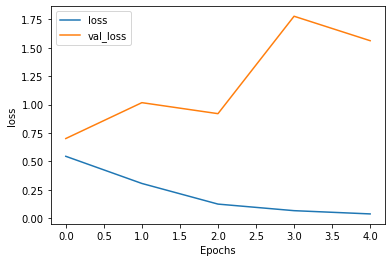

In [21]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### train_b modelfit and 学習

In [22]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
review_model_b.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model_names = "tf2_bert_review_b"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_names, "weights.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create! \n".format(checkpoint_dir))
    
cp_callback_b = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/tf2_bert_review_b -- Folder create! 



In [23]:
# 学習
history = review_model_b.fit(train_b_inputs, train_b_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback_b])

print(history.history)

Epoch 1/10
223/223 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.6882
Epoch 1: val_accuracy improved from -inf to 0.57323, saving model to /content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/tf2_bert_review_b/weights.h5
223/223 [==============================] - 60s 193ms/step - loss: 0.6014 - accuracy: 0.6882 - val_loss: 0.8385 - val_accuracy: 0.5732
Epoch 2/10
223/223 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.7855
Epoch 2: val_accuracy improved from 0.57323 to 0.84343, saving model to /content/drive/My Drive/Colab Notebooks/0.ML_data/OUT/tf2_bert_review_b/weights.h5
223/223 [==============================] - 42s 187ms/step - loss: 0.4627 - accuracy: 0.7855 - val_loss: 0.3548 - val_accuracy: 0.8434
Epoch 3/10
223/223 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8735
Epoch 3: val_accuracy did not improve from 0.84343
223/223 [==============================] - 39s 174ms/step - loss: 0.2911 - accuracy: 0

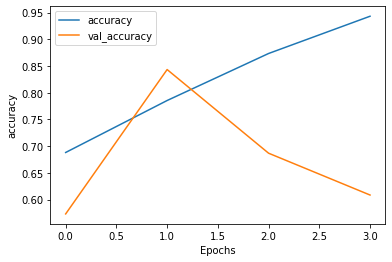

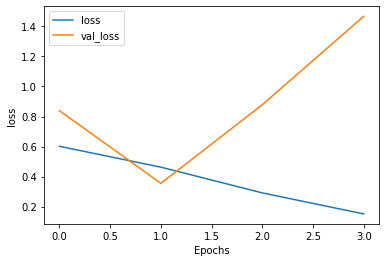

In [24]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# 学習したモデルで全体データの予測

#### データローディング

In [38]:
ML_DATA_IN_PATH= "/content/drive/My Drive/Colab Notebooks/"
sosiki_data=pd.read_csv(ML_DATA_IN_PATH + 'a_cleansing_complete_16461.csv',header=0,encoding="cp932",quoting=3)
sosiki_data.head()

,no,name,date,sex,retire,type,star,star2,label,label2,label3,review,review_cleansing
0,1,a0001,2022,1,1,0,2.6,2.6,0,2,2,良くも悪くも日本の伝統的大企業という感じ日本を支えてきた鉄鋼メーカーの自負があるがプライドが...,良くも悪くも日本の伝統的大企業という感じ日本を支えてきた鉄鋼メーカーの自負があるがプライドが...
1,2,a0001,2022,0,1,0,2.7,2.7,0,2,2,手続き多い何かトラブルが発生すると多くの反省振り返りを行う必要があり社是にある挑戦に対する風...,手続き多い何かトラブルが発生すると多くの反省振り返りを行う必要があり社是にある挑戦に対する風...
2,3,a0001,2022,0,1,0,2.2,2.2,0,2,0,石器時代かと思う社風会社の上層は変わろうとはしていても中位階層はついていけず変わる気配はなし...,石器時代かと思う社風会社の上層は変わろうとはしていても中位階層はついていけず変わる気配はなし...
3,4,a0001,2022,0,1,0,2.9,2.9,1,2,2,お互い異なる仕事をしているためか助け合う雰囲気はないなにか新しいことをやるチャレンジする際は...,お互い異なる仕事をしているためか助け合う雰囲気はないなにか新しいことをやるチャレンジする際は...
4,5,a0001,2022,0,1,0,3.1,3.1,1,2,2,良くも悪くも年功序列でトップダウンの風潮がある物腰の低い温和な性格の社員が多いイメージで人間...,良くも悪くも年功序列でトップダウンの風潮がある物腰の低い温和な性格の社員が多いイメージで人間...


#### encoding

In [39]:
# 데이터를 인코딩플러스 함수로 처리하는 for 구문

#각 반환값을 담을 리스트 작성
input_ids_sosiki=[]
attention_masks_sosiki=[]
token_type_ids_sosiki=[]
train_labels_sosiki=[]

# 학습데이터에서 인코딩플러스함수를 통해서 나온 값들을 작성한 리스트에 하나씩 담음
for train_sent, train_label in tqdm(zip(sosiki_data['review_cleansing'],sosiki_data['label3']),total=len(sosiki_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids_sosiki.append(input_id)
        attention_masks_sosiki.append(attention_mask)
        token_type_ids_sosiki.append(token_type_id)
        train_labels_sosiki.append(train_label)

#오류가 날 때에 오류 내용과 해당 문장 표시  
    except Exception as e:
        print(e)
        print(train_sent)
        pass

# 각 리스트를 넘파이 배열로 변환    
sosiki_input_ids = np.array(input_ids_sosiki,dtype=int) 
sosiki_attention_masks=np.array(attention_masks_sosiki, dtype=int)
sosiki_type_ids = np.array(token_type_ids_sosiki, dtype=int)



sosiki_inputs = (sosiki_input_ids, sosiki_attention_masks, sosiki_type_ids)
sosiki_labels=np.asarray(train_labels_sosiki, dtype=np.int32)

#총 학습데이터의 문장수 , 라벨수 확인

print("# sents: {}, # labels: {}".format(len(sosiki_input_ids), len(sosiki_labels)))

  0%|          | 0/16461 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 16461/16461 [00:08<00:00, 1937.42it/s]


# sents: 16461, # labels: 16461


#### モデル evalueate

In [41]:
results_sosiki = review_model_a.evaluate(sosiki_inputs, sosiki_labels, batch_size=16)########################
print("test loss, test acc: ", results_sosiki)

1029/1029 [==============================] - 72s 70ms/step - loss: nan - accuracy: 0.1290
test loss, test acc:  [nan, 0.12897150218486786]


#### データ予測

In [42]:
# 学習したモデルで予測・logit値取得
predictions_sosiki = review_model_a.predict(sosiki_inputs ,batch_size=16)

# 予測値を入れるリスト
predict_sosiki_labels=[]

# loopでlogit値→softmax関数→確率変換→ラベル分類
for i in predictions_sosiki:
    tf_prediction = tf.nn.softmax(i)
    label = tf.argmax(tf_prediction)
    label = label.numpy()
    predict_sosiki_labels.append(label)
    
# ラベル分布確認
print("number of test data :{}".format(len(predict_sosiki_labels)))
print("predict value of test a")
print(predict_sosiki_labels)
plt.hist(predict_sosiki_labels)

1029/1029 [==============================] - 75s 69ms/step
number of test data :16461
predict value of test a
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0

#### 予測値を元データに追加・csvにsave

In [44]:
sosiki_data['label4']=predict_sosiki_labels
DATA_OUT_PATH = "/content/drive/My Drive/Colab Notebooks/0.ML_data/"
sosiki_data.head()

,no,name,date,sex,retire,type,star,star2,label,label2,label3,review,review_cleansing,label4
0,1,a0001,2022,1,1,0,2.6,2.6,0,2,2,良くも悪くも日本の伝統的大企業という感じ日本を支えてきた鉄鋼メーカーの自負があるがプライドが...,良くも悪くも日本の伝統的大企業という感じ日本を支えてきた鉄鋼メーカーの自負があるがプライドが...,1
1,2,a0001,2022,0,1,0,2.7,2.7,0,2,2,手続き多い何かトラブルが発生すると多くの反省振り返りを行う必要があり社是にある挑戦に対する風...,手続き多い何かトラブルが発生すると多くの反省振り返りを行う必要があり社是にある挑戦に対する風...,0
2,3,a0001,2022,0,1,0,2.2,2.2,0,2,0,石器時代かと思う社風会社の上層は変わろうとはしていても中位階層はついていけず変わる気配はなし...,石器時代かと思う社風会社の上層は変わろうとはしていても中位階層はついていけず変わる気配はなし...,0
3,4,a0001,2022,0,1,0,2.9,2.9,1,2,2,お互い異なる仕事をしているためか助け合う雰囲気はないなにか新しいことをやるチャレンジする際は...,お互い異なる仕事をしているためか助け合う雰囲気はないなにか新しいことをやるチャレンジする際は...,0
4,5,a0001,2022,0,1,0,3.1,3.1,1,2,2,良くも悪くも年功序列でトップダウンの風潮がある物腰の低い温和な性格の社員が多いイメージで人間...,良くも悪くも年功序列でトップダウンの風潮がある物腰の低い温和な性格の社員が多いイメージで人間...,0


In [45]:
sosiki_data.to_csv(DATA_OUT_PATH + 'sosiki_predict_complete_16461.csv', index=False, quoting=3, encoding="CP932") 

#### 変数選択してcsvにsave（no +name+date+sex+retire+type+star2+label4+review dataset）

In [46]:
df=sosiki_data[['no','name','date','sex','retire','type','star2','label4','review_cleansing']]
df= pd.DataFrame(df)
df.to_csv(DATA_OUT_PATH + 'sosiki_complete_filter_16461.csv', index=False, quoting=3, encoding="CP932") 

# ラベルだけsave

In [56]:
sosiki_label=sosiki_data['label4']
sosiki_label=pd.DataFrame(sosiki_label)
sosiki_label.to_csv(DATA_OUT_PATH + 'sosiki_label_only.csv', index=False, quoting=3, encoding="CP932")